# Jaccard Similarity

**Created**: November 9 2021

## Environment

In [1]:
if (!require("pheatmap")) {
    install.packages("pheatmap")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required package: pheatmap

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(MASS)
library(RColorBrewer)
library(patchwork)
library(pheatmap)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘patchwork’


The following object is masked from ‘package:MASS’:

    area




## Load Data

In [3]:
jaccard.info <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/jaccard_values.tsv")
colnames(jaccard.info) <- c("Jaccard.Index", "Sample.1", "Sample.2")

head(jaccard.info)

,Jaccard.Index,Sample.1,Sample.2
,<dbl>,<chr>,<chr>
1,1.000000,Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control
2,0.418593,Calderon-1001-Bulk_B-Control,Calderon-1001-Gamma_delta_T-Control
3,0.432688,Calderon-1001-Bulk_B-Control,Calderon-1001-Central_memory_CD8pos_T-Control
4,0.396941,Calderon-1001-Bulk_B-Control,Calderon-1001-Memory_NK-Control
5,0.424132,Calderon-1001-Bulk_B-Control,Calderon-1001-Mature_NK-Control
6,0.446370,Calderon-1001-Bulk_B-Control,Calderon-1001-CD8pos_T-Control


In [27]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")

sample.info <- sample.info %>%
    dplyr::select(Group.ID, Donor, Cell.Type=Cell_type, Lineage, Stimulated, Treatment) %>%
    dplyr::mutate(Donor=factor(Donor), Cell.Type=factor(Cell.Type), Lineage=factor(Lineage)) %>%
    unique()

rownames(sample.info) <- sample.info$Group.ID

## Jaccard Heatmap

The `bedtools` suite provides a [Jaccard measure](https://bedtools.readthedocs.io/en/latest/content/tools/jaccard.html) of similarity between two peak sets. In brief, the Jaccard measure of similarity between two sets $A$ and $B$ is

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

In the case of peaks, $|A \cap B|$ is taken to be the base pairs that are commonly covered by both peak sets. In contrast, $|A \cup B|$ is taken to be all the base pairs that are covered by combining peaks from both peak sets.

In [20]:
jaccard.mtx <- jaccard.info %>%
    tidyr::spread(Sample.2, Jaccard.Index) %>%
    dplyr::select(-Sample.1) %>%
    as.matrix()
rownames(jaccard.mtx) <- colnames(jaccard.mtx)

no.treatment.samples <- sample.info$Group.ID[sample.info$Treatment=="Control"]
jaccard.mtx.no.treatment <- jaccard.mtx[no.treatment.samples, no.treatment.samples]

annotation <- sample.info %>%
    dplyr::select(Lineage, Donor)
annotation <- annotation[no.treatment.samples,]

annotation.cols <- list(
    Donor=setNames(colorRampPalette(brewer.pal(11, "Spectral"))(14), levels(annotation$Donor)),
    Lineage=setNames(brewer.pal(6, "Pastel1"), levels(annotation$Lineage))
)

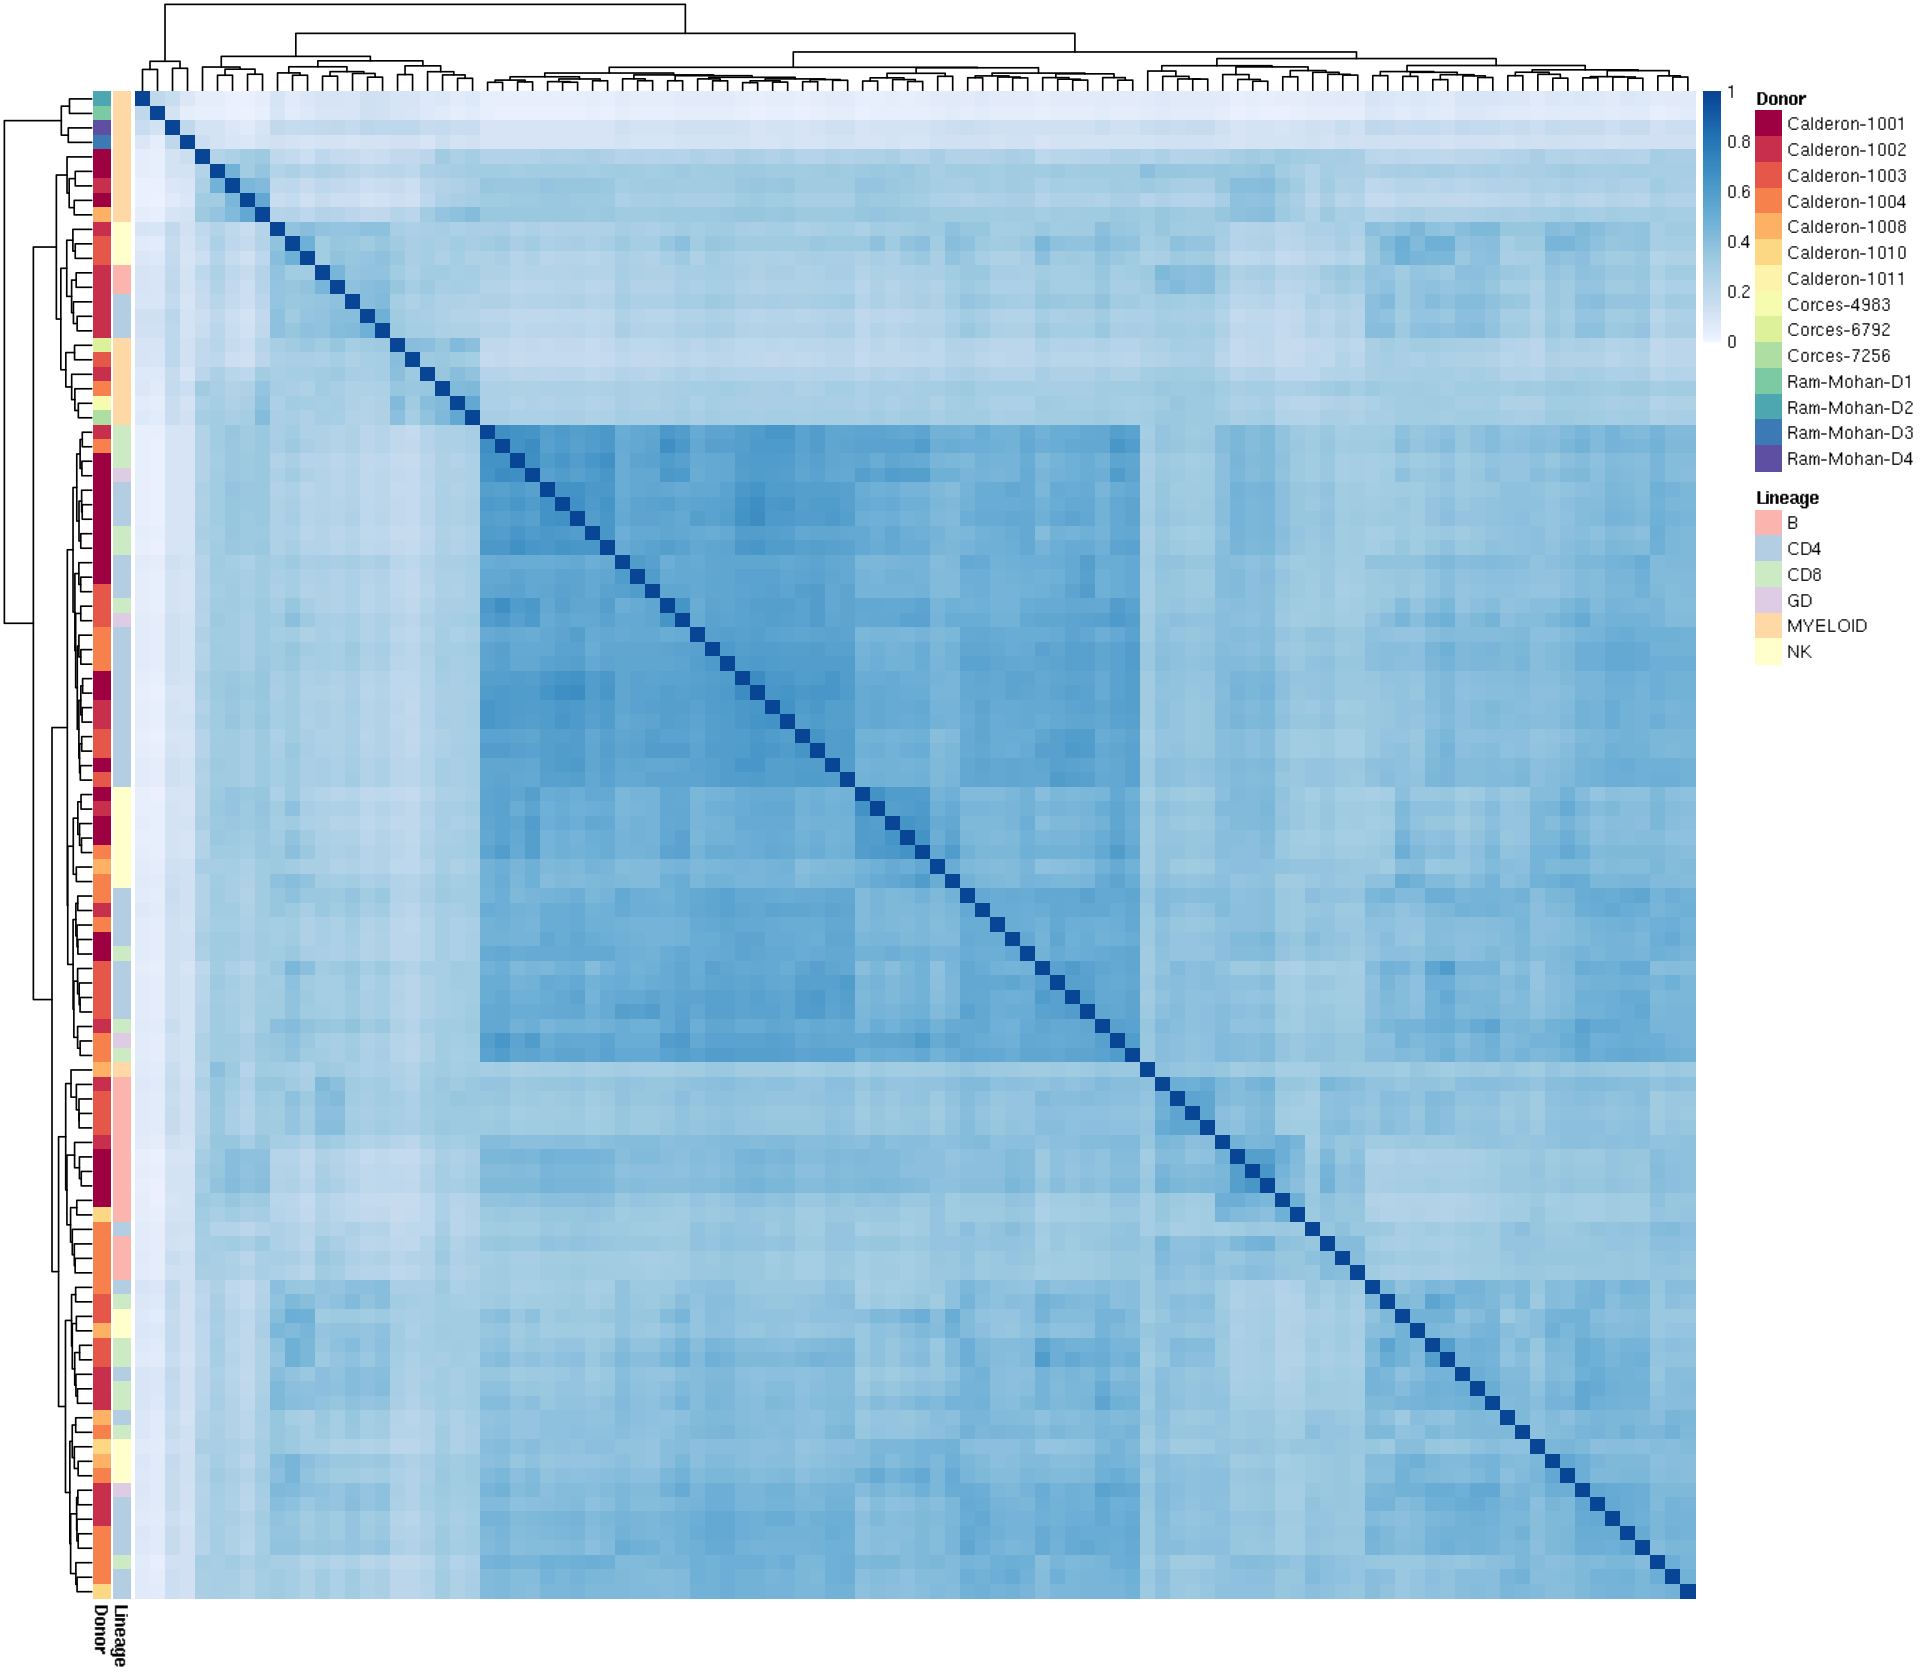

In [23]:
options(repr.plot.width=16, repr.plot.height=14)
pheatmap(
    jaccard.mtx.no.treatment,
    color=colorRampPalette(brewer.pal(7, "Blues"))(100),
    breaks=seq(0, 1, length.out=101),
    annotation_row=annotation,
    annotation_colors=annotation.cols,
    show_rownames=F, show_colnames=F,
    border_color="white"
)

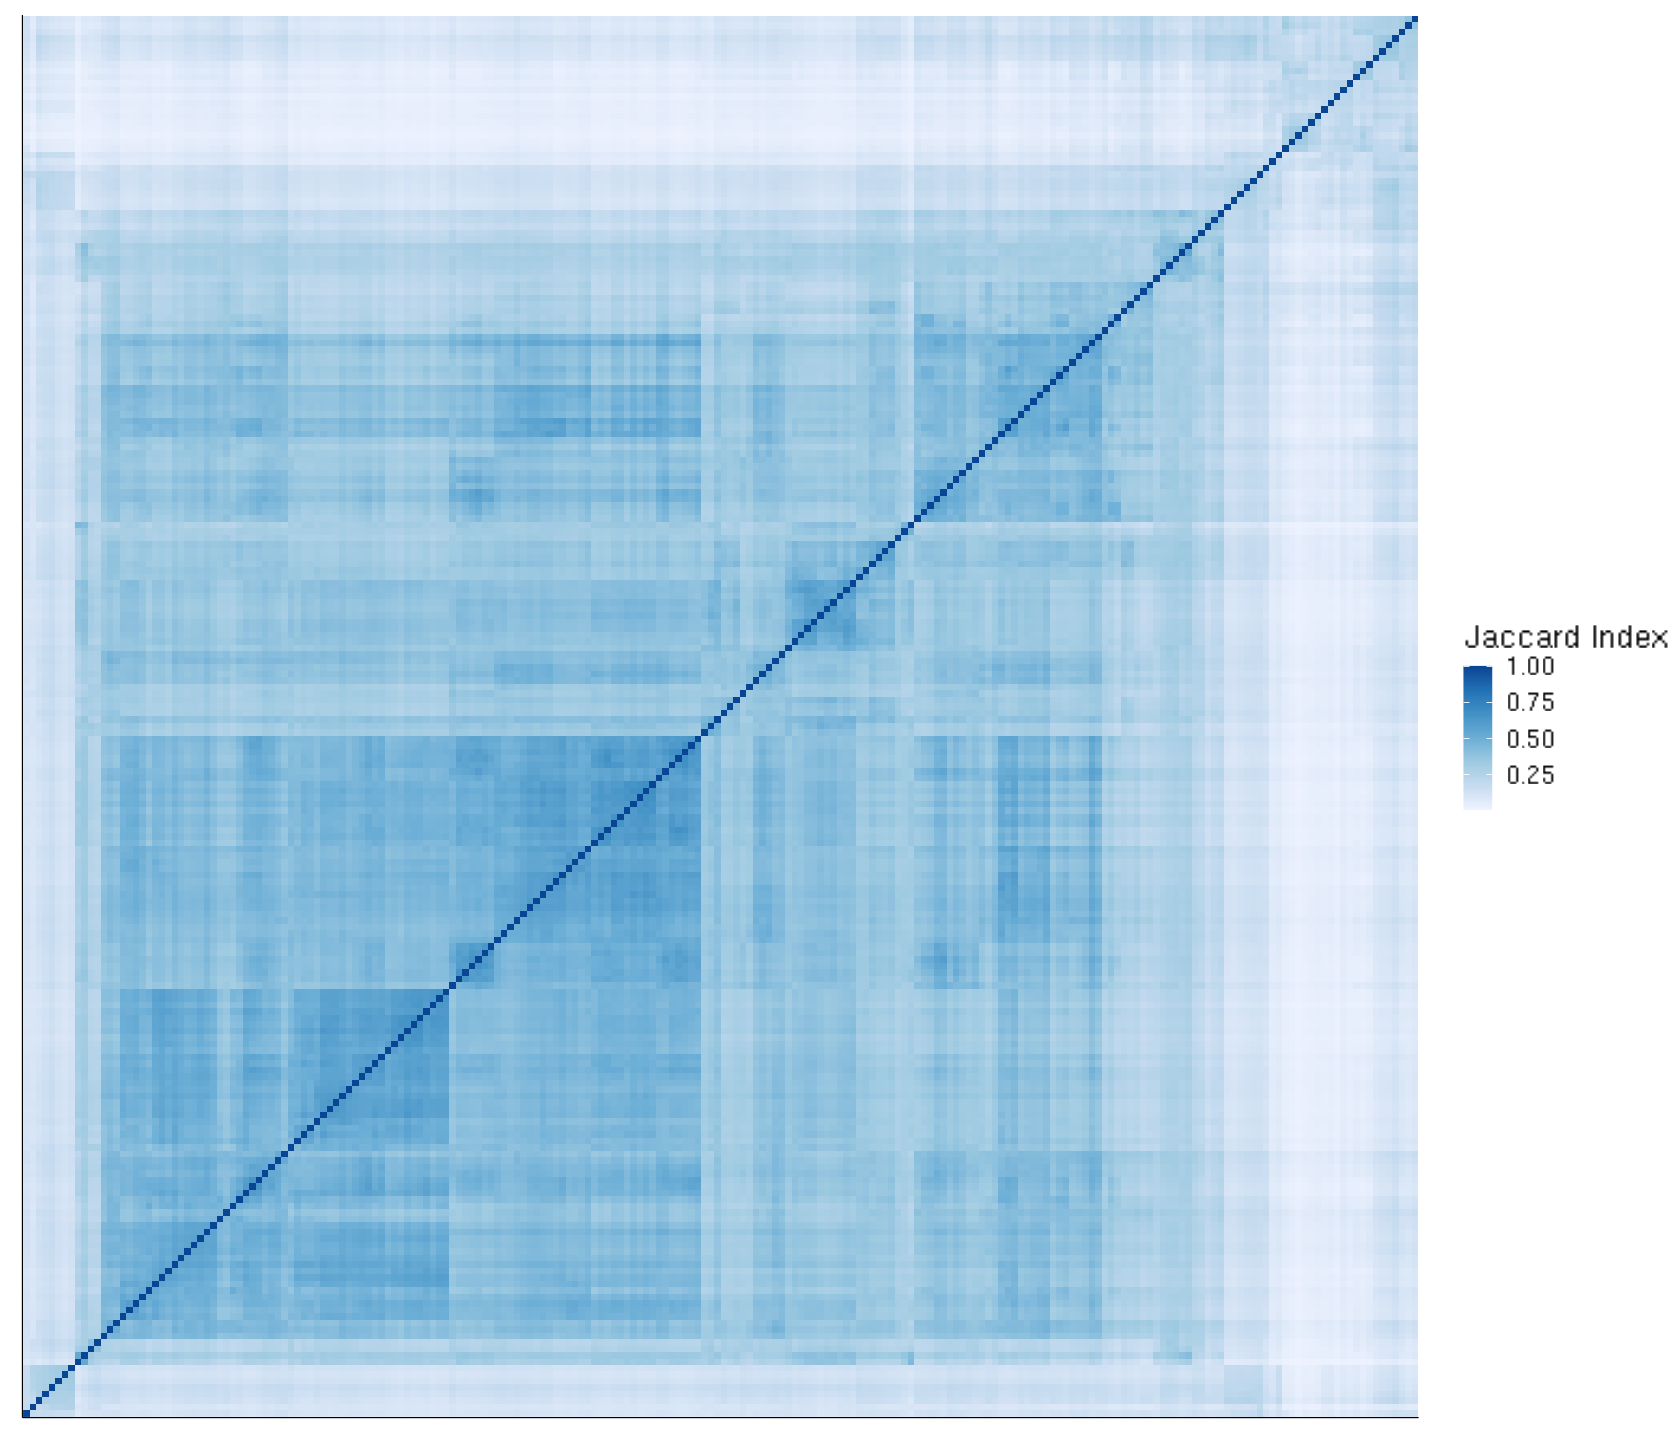

In [24]:
h <- hclust(as.dist(1 - jaccard.mtx))

options(repr.plot.width=14, repr.plot.height=12)
jaccard.info %>%
    dplyr::mutate(Sample.1=factor(Sample.1, levels=rownames(jaccard.mtx)[h$order])) %>%
    dplyr::mutate(Sample.2=factor(Sample.2, levels=colnames(jaccard.mtx)[h$order])) %>%
    ggplot() +
    geom_raster(aes(x=Sample.1, y=Sample.2, fill=Jaccard.Index)) +
    scale_fill_distiller("Jaccard Index", palette="Blues", direction=1) +
    ggplot_theme +
    theme(axis.text=element_blank(), axis.title=element_blank(), axis.ticks=element_blank(), legend.position="right")
ggsave("03_Functional_Interpretation/results/peak_jaccard_matrix.svg", width=14, height=12)

## Multidimensional Scaling

Since the Jaccard Index is a measure of similarity, it cannot be subjected to analysis using Principal Component Analysis (PCA) directly. Multidimensional scaling (MDS) is a more general approach to visualizing similarity between samples in a lower-dimensional space. MDS has the advantage of using distance matrices rather than the sample matrix. Non-metric MDS does not assume that the distance measure is within a metric space.

In [25]:
fit <- isoMDS(as.dist(1 - jaccard.mtx), k=2)

initial  value 28.486417 
iter   5 value 13.236146
iter  10 value 9.945416
iter  15 value 9.033447
iter  20 value 8.773259
iter  25 value 8.585572
final  value 8.515728 
converged


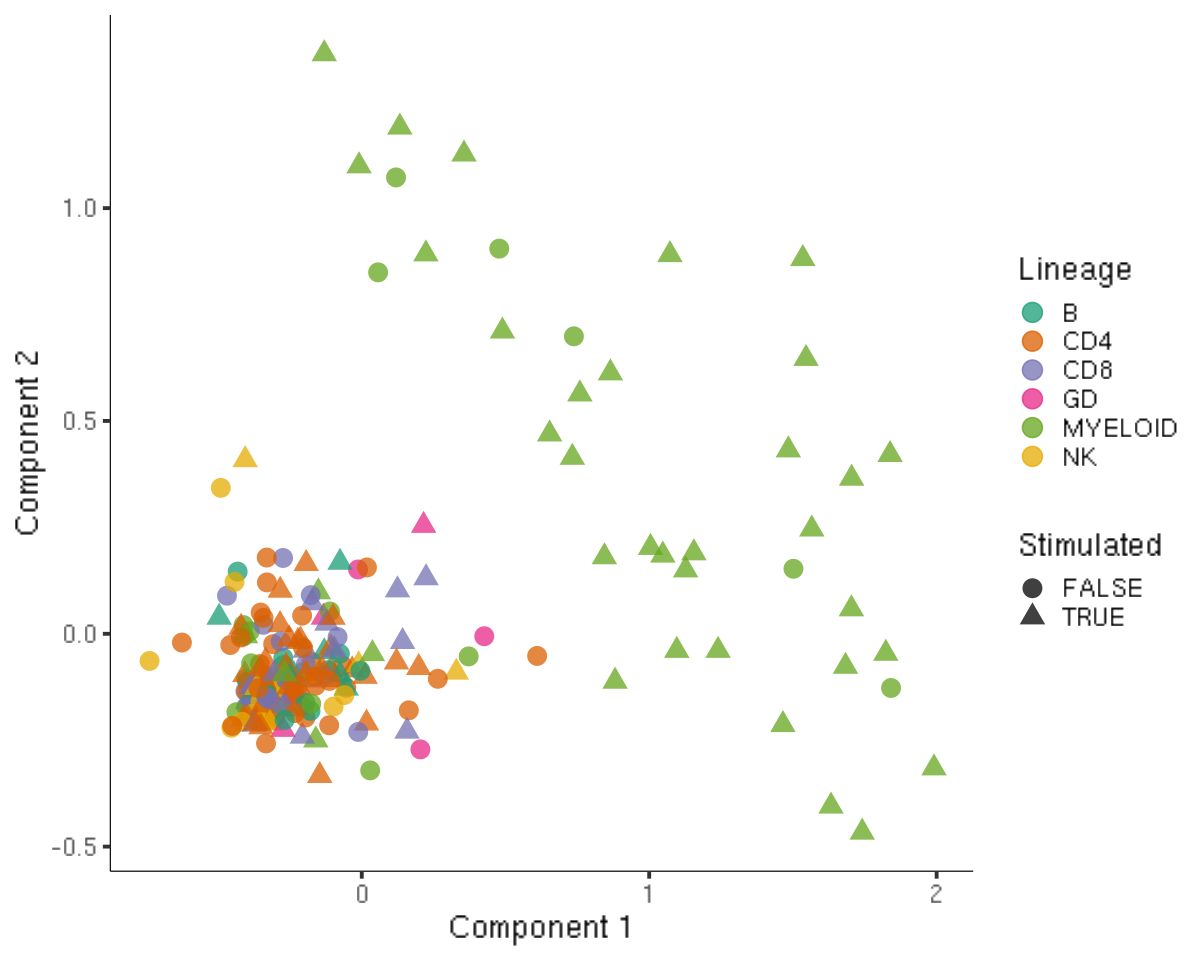

In [28]:
options(repr.plot.width=10, repr.plot.height=8)
fit$points %>%
    as.data.frame() %>%
    dplyr::select(Component.1=1, Component.2=2) %>%
    dplyr::bind_cols(sample.info) %>%
    ggplot() +
    geom_point(aes(x=Component.1, y=Component.2, color=Lineage, shape=Stimulated), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme +
    theme(legend.position="right")
ggsave("03_Functional_Interpretation/results/peak_jaccard_mds.svg", width=10, height=8)